<h1><center>Sartorius: Cell Instance Segmentation</center></h1>
                                                      
<center><img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS75MhDku1itW_qJxDfBwBywPP2ROhw0Vh9Dah3QllbkQW1h9gvBsQnWkScUikzJ7mvPJM&usqp=CAU" width = "750" height = "500"/></center>    

<h1><center>Load Modules</center></h1>

In [1]:
import os
import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision

from torchvision.transforms import functional as F
#import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2

import albumentations as A
import albumentations.pytorch
from albumentations import (HorizontalFlip, VerticalFlip, 
                            ShiftScaleRotate, Normalize, Resize, 
                            Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2



import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import GPUtil
from GPUtil import showUtilization as gpu_usage

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from jupyterthemes import jtplot
import warnings

import time
from functools import wraps
import functools
import collections

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

#torch.backends.cudnn.benchmark = True
#torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.cuda.manual_seed_all(n)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(n)
    
set_random(42)

<h1><center>General Configurations</center></h1>

In [4]:
data_dir = './sartorius-cell-instance-segmentation'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 2
NUM_EPOCHS = 5
TRAIN_CSV = f"{data_dir}/train.csv"
TRAIN_PATH = f"{data_dir}/train"
TEST_PATH = f"{data_dir}/test"

WIDTH = 704
HEIGHT = 520
# Threshold for mask length
TH = 40
BATCH_SIZE = 2
WEIGHT_DECAY = 0.0005


# Normalize to resnet mean and std if True.
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]
IMAGE_RESIZE = (224, 224)


cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Load the data</center></h2>

In [5]:
train_files = sorted(list(Path(TRAIN_PATH).rglob('*png')))
test_files = sorted(list(Path(TEST_PATH).rglob('*.png')))
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


In [6]:
cell_df = pd.read_csv(TRAIN_CSV)
cell_df.info()
cell_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
65518,de504eaa5349,252178 6 252881 8 253585 9 254288 10 254992 11...,704,520,shsy5y,11h30m00s,2019-06-15,shsy5y[diff]_D12-1_Vessel-714_Ph_2,0 days 11:30:00
48139,a76fe4d00355,112202 6 112905 10 113608 11 114314 9 115018 9...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_E10-2_Vessel-714_Ph_3,0 days 11:30:00
37042,836e5872684a,268741 3 269440 10 270138 18 270839 23 271544 ...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D12-4_Vessel-714_Ph_4,0 days 11:30:00
60537,d09291445961,125348 8 126050 11 126753 13 127457 15 128162 ...,704,520,astro,09h00m00s,2020-09-14,astros[cereb]_F8-2_Vessel-361_Ph_4,0 days 09:00:00


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Utilits</center></h2>

In [7]:
def rle_decode(mask_rle,shape,color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    if colors = 1, then:
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    # get starting pixel and cells's length
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -=1
    # Ending pixels
    ends = start + length
    img = np.zeros((shape[0] * shape[1], shape [2]), dtype=np.float32)
    for lo, hi in zip (start, ends):
        img[lo : hi] = color
    return img.reshape(shape)

Masks have an abnormally long continuous lines.

The mask is not representative enough.

We can take only correct masks to train our model.

**Thanks** [Slavko Prytula](https://www.kaggle.com/slavkoprytula/mask-correction-mask-filtering-updated#Utils)

In [8]:
def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

In [9]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    masks = np.zeros((height, width, 1))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle_decode(label, shape=(height,width, 1))
        a_mask = np.array(a_mask) > 0 
        a_mask, broken_mask = clean_mask(a_mask)
        if broken_mask:
            continue
        masks += a_mask
    masks = masks.clip(0,1)
    return masks

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize the Data</center></h2>

--- 0.0009353160858154297 seconds in label ---
--- 0.00499415397644043 seconds in sorting df ---
--- 5.238097429275513 seconds in mask1 ---
--- 5.205607652664185 seconds in mask2 ---


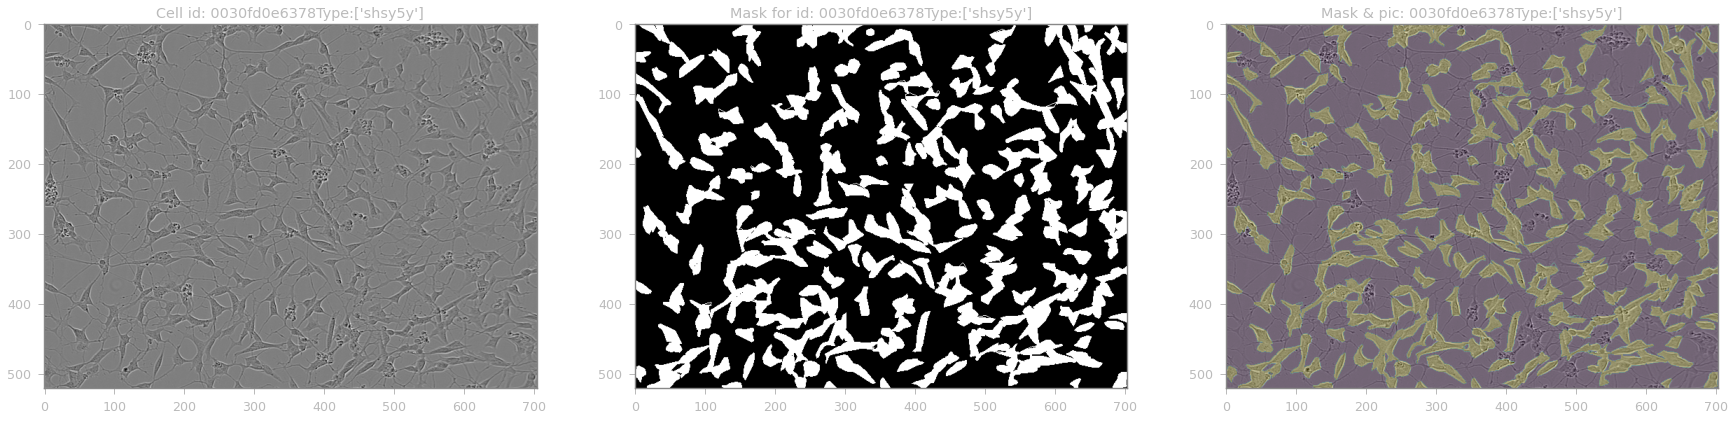

--- 0.0005395412445068359 seconds in label ---
--- 0.0029523372650146484 seconds in sorting df ---
--- 1.2403130531311035 seconds in mask1 ---
--- 1.2550108432769775 seconds in mask2 ---


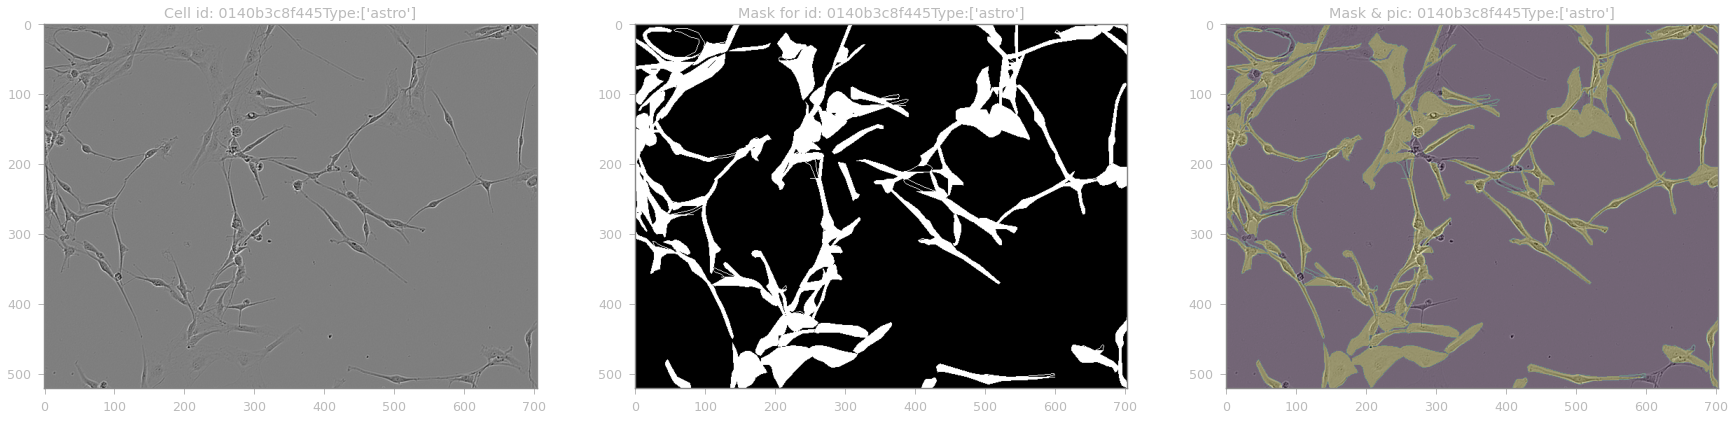

--- 0.0005631446838378906 seconds in label ---
--- 0.0032253265380859375 seconds in sorting df ---
--- 0.4223048686981201 seconds in mask1 ---
--- 0.43947410583496094 seconds in mask2 ---


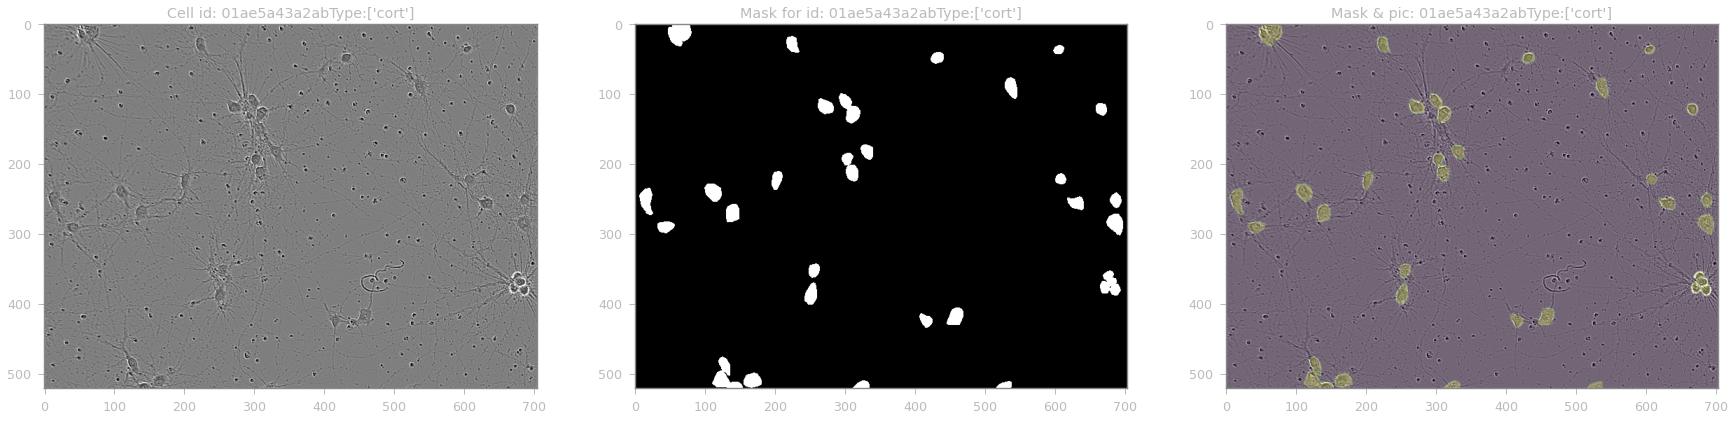

--- 0.0005428791046142578 seconds in label ---
--- 0.0031845569610595703 seconds in sorting df ---
--- 0.5037722587585449 seconds in mask1 ---
--- 0.4858424663543701 seconds in mask2 ---


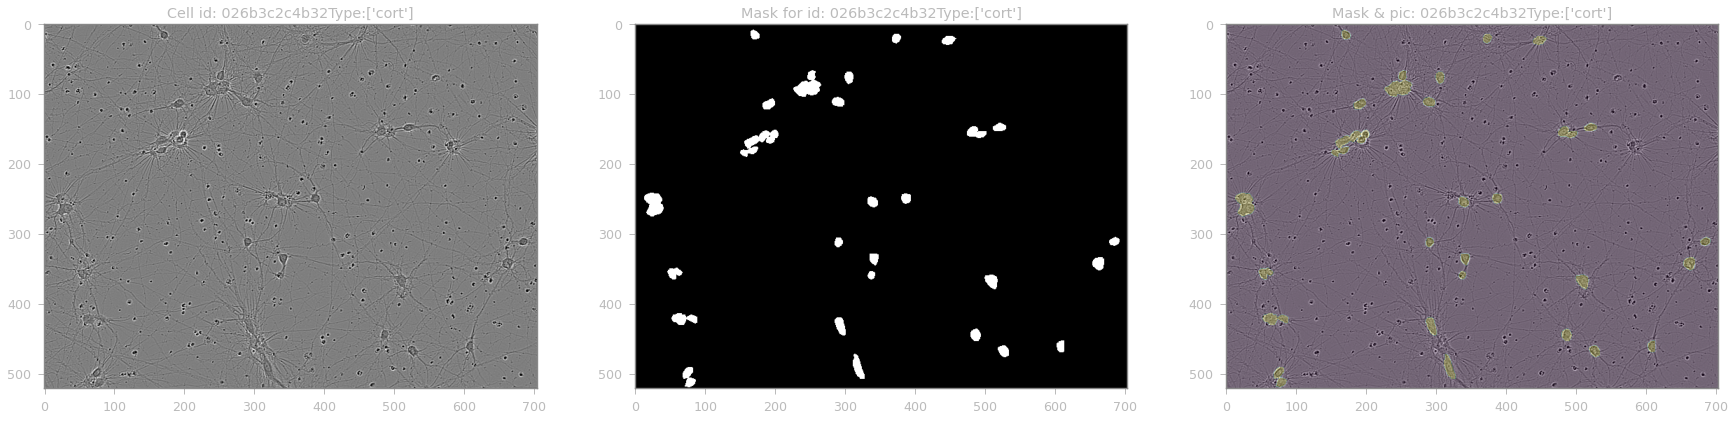

In [10]:
temp = cell_df.groupby(['id','cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
for i in range(4):
    #rand_idx = int(np.random.uniform(0, 607))
    #im = PIL.Image.open(train_files[rand_idx])
    im = PIL.Image.open(train_files[i])
    
    start = time.time()
    label = (train_files[i]).stem
    
    cell_type = temp[temp['id'] == label]
    cell_type = str(cell_type['cell_type'].values)
    print("--- %s seconds in label ---" % (time.time() - start))
    
    start = time.time()
    sample_im_df = cell_df[cell_df['id'] == label]
    print("--- %s seconds in sorting df ---" % (time.time() - start))
    
    sample_rles = sample_im_df['annotation'].values
    start = time.time()
    sample_masks1 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=False)
    print("--- %s seconds in mask1 ---" % (time.time() - start))
    
    start = time.time()
    sample_masks2 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=True)
    print("--- %s seconds in mask2 ---" % (time.time() - start))
    
    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20),)
    ax1.imshow(im,cmap='gray')
    ax2.imshow(sample_masks1, cmap='gray')
    ax3.imshow(im,cmap='gray')
    ax3.imshow(sample_masks2,alpha = .2)
    
    ax1.set_title('Cell id: ' + str(label) + 'Type:' + str(cell_type))
    ax2.set_title('Mask for id: ' + str(label) + 'Type:' + str(cell_type))
    ax3.set_title('Mask & pic: ' + str(label) + 'Type:' + str(cell_type))
    plt.show();
del temp, im, sample_masks1, sample_masks2

<h1><center>Preparing DataSets And DataLoaders</center></h1>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Define Augmenting</center></h2>

In [11]:
def get_augmentation(pic_size,mode):
    if mode !='train':
        augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
                                                    A.Normalize(
                                                        mean=RESNET_MEAN,
                                                        std=RESNET_STD),
                                                    A.pytorch.transforms.ToTensorV2()])
        return augmentation_test
    else:
        augmentation_train = A.Compose([
            A.Resize(pic_size,pic_size),
            A.RandomCrop(pic_size, pic_size),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.VerticalFlip(p=0.5)], p=0.5),
#             A.OneOf([
#                 A.GaussNoise(),], p=0.8),
#             A.OneOf([
#                 A.OpticalDistortion(p=0.3),
#                 A.GridDistortion(p=0.1),], p=0.8),
#             A.OneOf([
#                 A.CLAHE(clip_limit=2),
#                 A.RandomBrightnessContrast(),], p=0.5),
#             A.HueSaturationValue(p=0.3),
            A.Normalize(
                mean=RESNET_MEAN,
                std=RESNET_STD),
            A.pytorch.transforms.ToTensorV2()], p=1)
        return augmentation_train

In [12]:
class NeuroDataSet(Dataset):
    def __init__(self, files, df: pd.core.frame.DataFrame,train:bool, transform=None):   
        self.files = files
        self.df = df
        #self.transform = transform
        self.height = HEIGHT
        self.width = WIDTH
        self.gb = self.df.groupby('id')
        #self.transform = transform
        self.transforms_tr = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                                   HorizontalFlip(p=0.5),
                                   VerticalFlip(p=0.5),
                                   ToTensorV2()])
        self.transforms_tst = Compose([Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                                   Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1),
                                   ToTensorV2()])
        self.len_ = len(self.files)
        self.train = train
        
    
    def load_sample(self, file):
        img = cv2.imread(str(file), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self,index):
        # load image
        img, img_id = self.load_sample(self.files[index])
        df_temp = self.gb.get_group(img_id)
        
        annotations = df_temp['annotation'].values
        mask = build_mask(annotations, (self.height,self.width), colors=False)
        mask = mask.astype('float32')
#         if self.transform is not None:
#             augmented = self.transform(image = img, mask = mask)
#             img = augmented['image']
#             mask = augmented['mask']
#             return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
#         else:
#             return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
        if self.train:
            augmented = self.transforms_tr(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
        else:
            augmented = self.transforms_tst(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
     
    def __len__(self):
        return self.len_

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Split train-val set</center></h2>

In [13]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.1)

In [14]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 545

Number of pictures in val set: 61


In [15]:
# split pandas dataframe with annotations for train df and val df
# in consistance with given file Ids
df_train = cell_df[(cell_df['id'].isin(train_pic_id))]
df_val = cell_df[(cell_df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 545

Number of picture's id in val set 61


In [16]:
train_dataset = NeuroDataSet(train_pics,
                             df_train,
                             train = True,
                             #transform=get_augmentation(224, 'train')
                            )

In [17]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=12,)

In [18]:
val_dataset = NeuroDataSet(val_pics,
                           df_val,train=False,
                          # transform=get_augmentation(224, 'val')
                          )

In [19]:
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=12,)

In [20]:
batch = next(iter(train_loader)) 
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")
del batch, images, masks

image shape: torch.Size([2, 3, 224, 224]),
mask shape:torch.Size([2, 1, 224, 224]),
batch len: 2


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize Augmented DataSet</center></h2>

In [21]:
def visualize_augmentations(dataset, idx=1, samples=6, cols=3):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, A.pytorch.ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i in range(samples):
        image, mask = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    del dataset

In [22]:
visualize_augmentations(train_dataset,idx=2)

AttributeError: 

In [23]:
# Create convolution block class
class Conv_Block(nn.Module):
    '''convolution ==> BN ==> ReLU'''
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [24]:
class Encoder(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Conv_Block(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = x.cuda()
        return self.maxpool_conv(x)

In [25]:
class Decoder(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = Conv_Block(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = x1.cuda()
        x2 = x2.cuda()
        x1 = self.up(x1)
#         # input CxHxW
#         diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
#         diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [26]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [27]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = Conv_Block(n_channels, 64)
        self.enc1 = Encoder(64, 128)
        self.enc2 = Encoder(128, 256)
        self.enc3 = Encoder(256, 512)
        self.enc4 = Encoder(512, 512)
        self.dec1 = Decoder(1024, 256, bilinear)
        self.dec2 = Decoder(512, 128, bilinear)
        self.dec3 = Decoder(256, 64, bilinear)
        self.dec4 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.outc(x)
        return logits

In [28]:
print(f"Initial GPU Usage at fit_epoch")
gpu_usage()

Initial GPU Usage at fit_epoch
| ID | GPU | MEM |
------------------
|  0 | 10% | 23% |


In [29]:
import segmentation_models_pytorch as smp
from Losses import ComboLoss, dice_metric

In [30]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
Jaccard     = smp.losses.JaccardLoss(mode='binary', from_logits=False)
Dice        = smp.losses.DiceLoss(mode='binary', from_logits=False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def criterion(y_pred, y_true):
    return JaccardLoss(y_pred, y_true)

In [31]:
def train_loop(model, optimizer, criterion, train_loader, device=DEVICE):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]  # += loss * current batch size
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    return running_loss

In [32]:
def eval_loop(model, criterion, eval_loader, device=DEVICE):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}


In [33]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=DEVICE, 
          num_epochs=15, 
          valid_loss_min=np.inf,
          logdir='logdir'):
    
    history = []
    tb_writer = SummaryWriter(log_dir=logdir)
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        history.append((train_loss,metrics["loss"],metrics["accuracy"]))
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)


        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'UNet.pt')
            valid_loss_min = metrics["loss"]
    return history

In [34]:
# set_seed(21)
model = UNet(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY )
criterion = BCELoss

In [35]:
history = train(model, optimizer, criterion, train_loader, val_loader)

Iterating over evaluation data: 100%|███████████| 31/31 [00:24<00:00,  1.28it/s]


Epoch: 1 TrainLoss: 0.26563 ValidLoss: 0.19837 ACC: 0.90574 F1: 0.239


Iterating over evaluation data: 100%|███████████| 31/31 [00:24<00:00,  1.29it/s]


Epoch: 2 TrainLoss: 0.23085 ValidLoss: 0.21528 ACC: 0.92695 F1: 0.542


Iterating over evaluation data: 100%|███████████| 31/31 [00:24<00:00,  1.24it/s]


Epoch: 3 TrainLoss: 0.22272 ValidLoss: 0.21399 ACC: 0.90920 F1: 0.279


Iterating over train data:  45%|██████▎       | 124/273 [01:20<01:36,  1.54it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED